In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd # data processing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Dropout,LSTM, Bidirectional
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.layers import BatchNormalization, Dropout
from keras.layers import Dense, Activation
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import torch
from torch.nn import Transformer
from sklearn.preprocessing import StandardScaler #bad
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler

In [2]:
DATA_FOLDER = "./"
USER_ID = "N01T1"
keypoint_csv = DATA_FOLDER + "train/{}_keypoint.csv".format(USER_ID)
ann_csv = DATA_FOLDER + "/ann/{}_ann.csv".format(USER_ID)
standartscaler=MaxAbsScaler()

TEST_ID = "N02T1"
test_keypoint_csv = DATA_FOLDER + "/train/{}_keypoint.csv".format(TEST_ID)
test_ann_csv = DATA_FOLDER + "/ann/{}_ann.csv".format(TEST_ID)

In [3]:
FS = 30 # sampling rate
TOTAL_CLASSESS = 9

In [4]:
def load_data(keypoint_csv, ann_csv):
    kp_df = pd.read_csv(keypoint_csv)
    kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('^Unnamed')]

    ann_df = pd.read_csv(ann_csv)
    ann_df = ann_df.loc[:, ~ann_df.columns.str.contains('^Unnamed')]

    return kp_df, ann_df

In [5]:
kp_df, ann_df = load_data(keypoint_csv, ann_csv)

test_kp_df, test_ann_df = load_data(test_keypoint_csv, test_ann_csv)

In [6]:
keypoint_position = "left_wrist"  # choose keypoint you want to visualize

In [7]:
KEYPOINTS_DICT = {"nose": 0,
                  "left_eye": 1,
                  "right_eye": 2,
                  "left_ear": 3,
                  "right_ear": 4,
                  "left_shoulder": 5,
                  "right_shoulder": 6,
                  "left_elbow": 7,
                  "right_elbow": 8,
                  "left_wrist": 9,
                  "right_wrist": 10,
                  "left_hip": 11,
                  "right_hip": 12,
                  "left_knee": 13,
                  "right_knee": 14,
                  "left_ankle": 15,
                  "right_ankle": 16}

values = np.array(kp_df)[:, int(KEYPOINTS_DICT[keypoint_position]*3):int(KEYPOINTS_DICT[keypoint_position]*3 + 3)]

<Figure size 3000x1500 with 0 Axes>

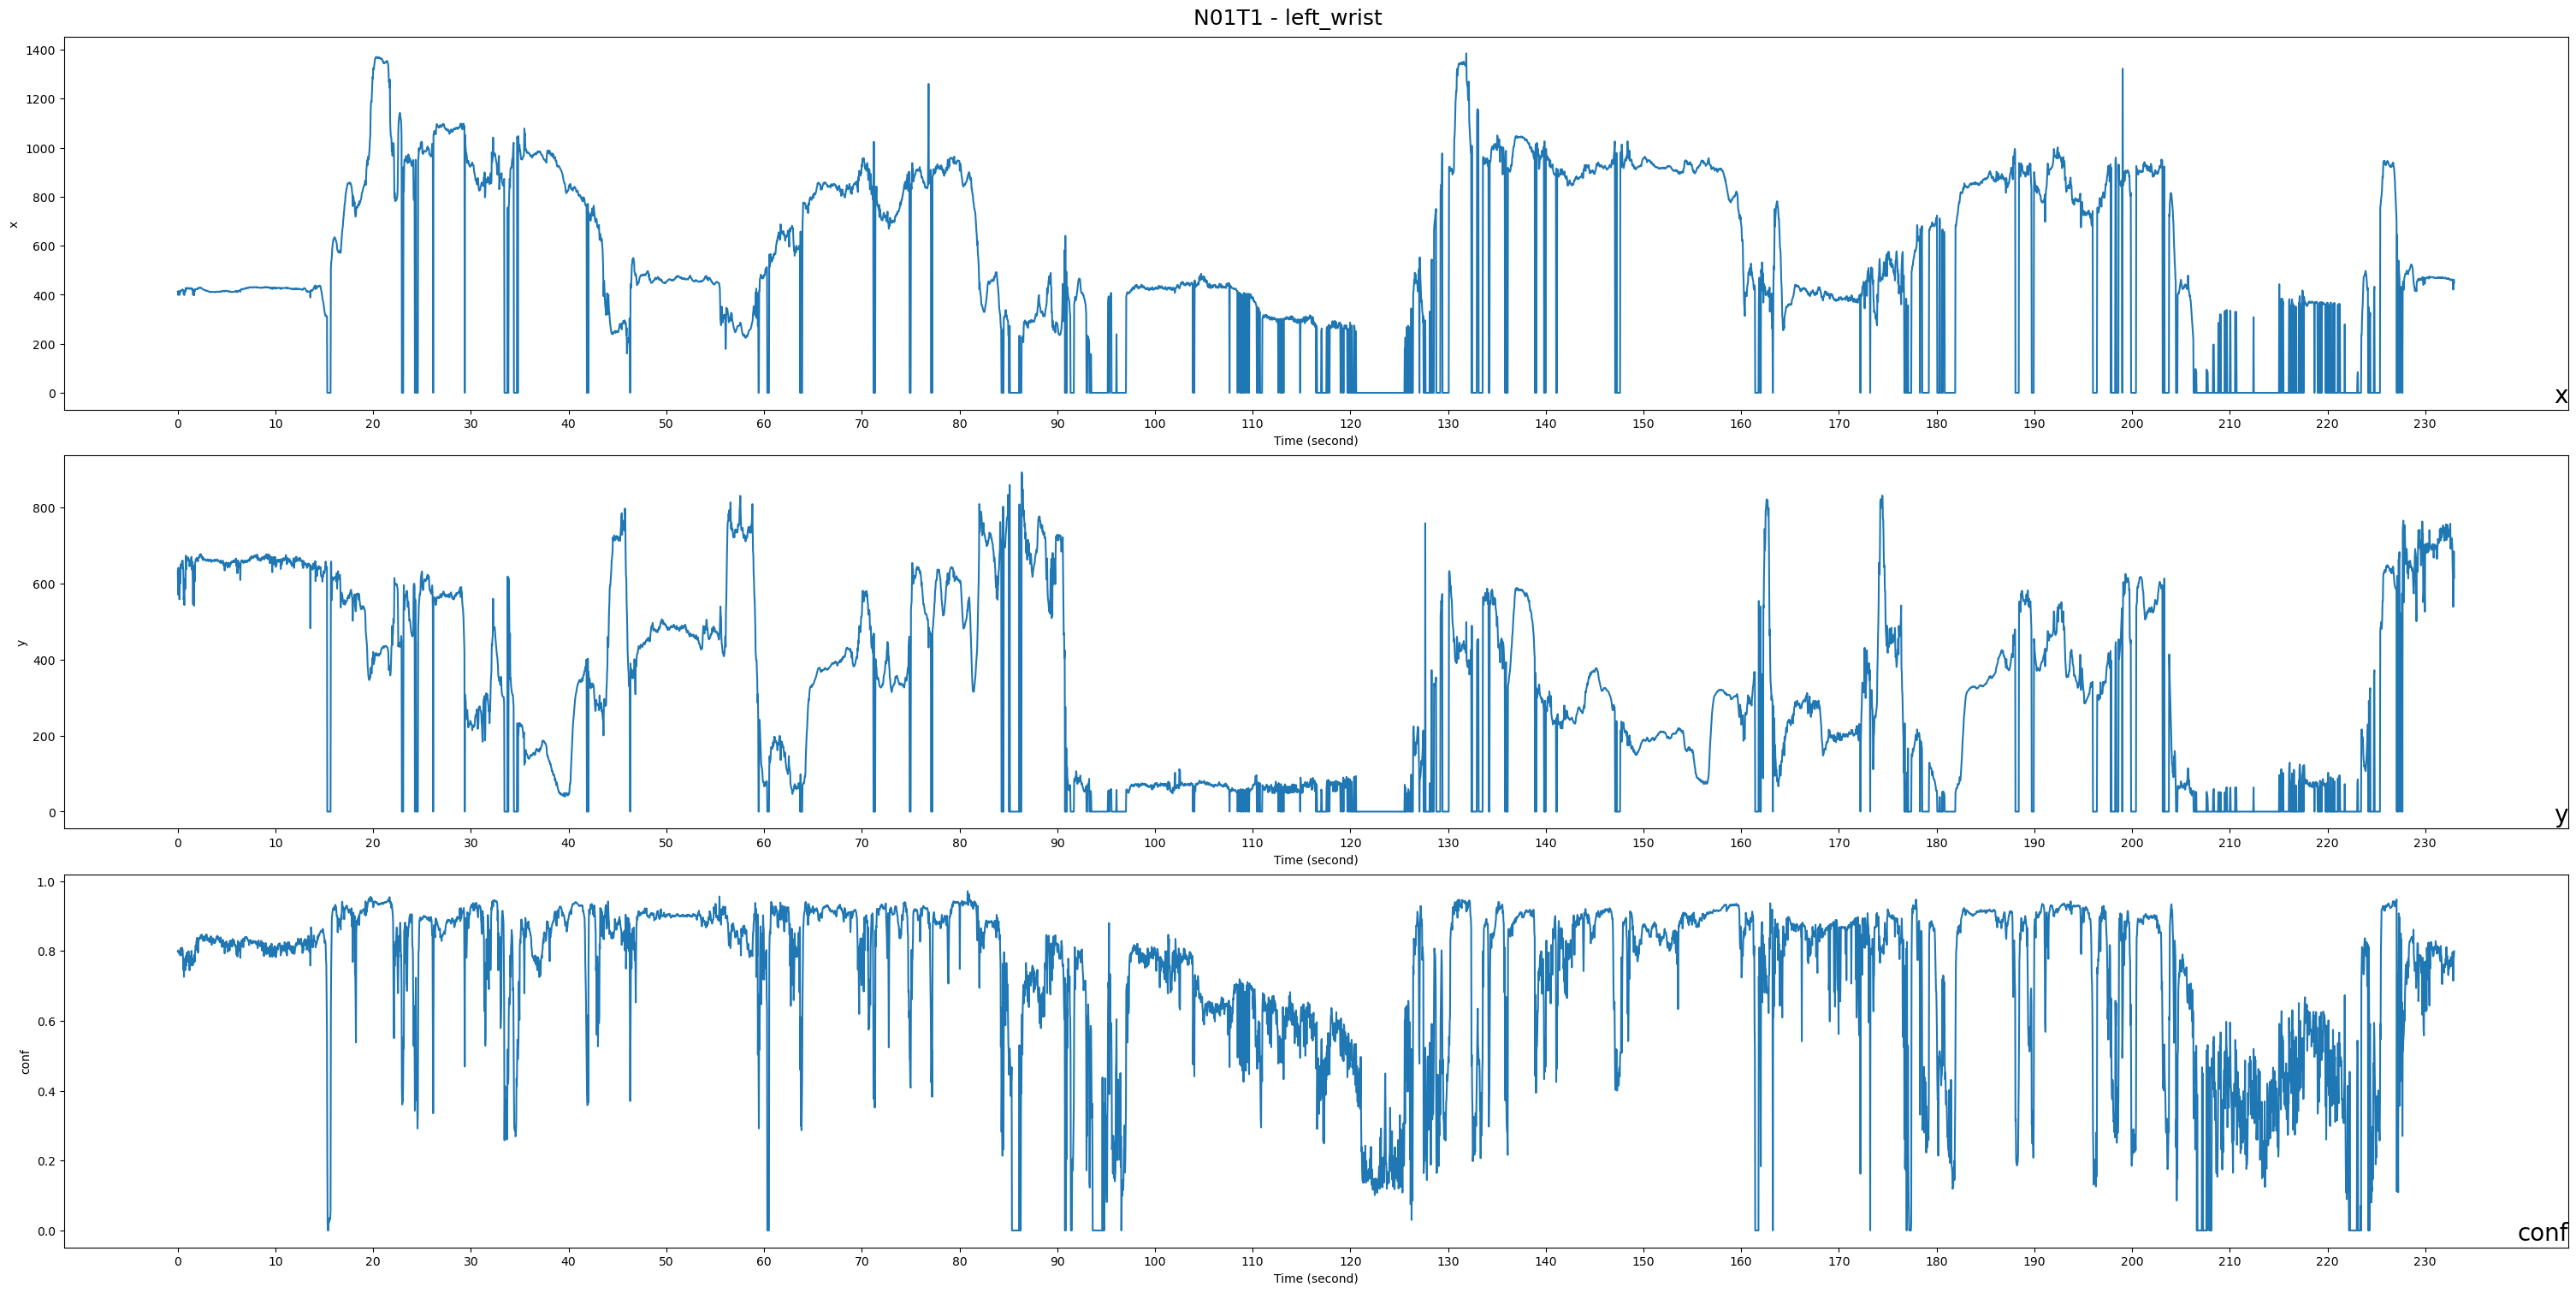

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,15))
fig, axs = plt.subplots(3, 1, figsize=(30,15),  layout="constrained")
cols_name = ["x", "y", "conf"]
for x in range(3):
    axs[x].plot(values[:, x])
    axs[x].set_title(cols_name[x], y=0, loc='right', fontsize=20)
    axs[x].set_xlabel("Time (second)")
    axs[x].set_ylabel(cols_name[x])

x_ticks = np.arange(0, len(values), 10*FS)
x_ticklabels = np.arange(0, len(x_ticks))*10
plt.setp(axs, xticks=x_ticks, xticklabels=x_ticklabels)
fig.suptitle('{} - {}'.format(USER_ID, keypoint_position), size=18)
plt.show()

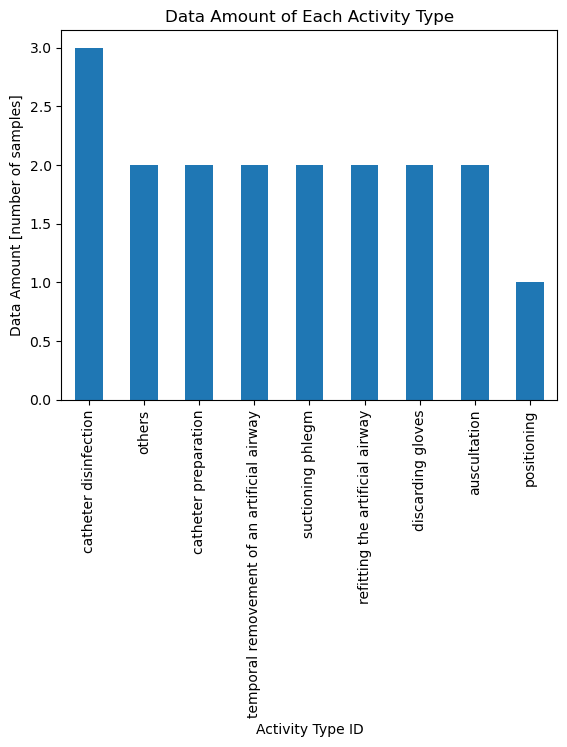

In [9]:
tmp_data_count = ann_df['annotation_str'].value_counts()
tmp_data_count.plot(kind='bar')
plt.title('Data Amount of Each Activity Type')
plt.xlabel('Activity Type ID')
plt.ylabel('Data Amount [number of samples]')

plt.show()

del tmp_data_count

In [10]:
def remove_redundant_kp(kp_df):
    kp_df = kp_df.loc[:, ~kp_df.columns.str.contains(
    'conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]
    return kp_df

In [11]:
kp_df = remove_redundant_kp(kp_df)

test_kp_df = remove_redundant_kp(test_kp_df)

In [12]:
SMOOTH_LEN = 3 # seconds

def smooth_kp(kp_col):
    zero_idx = np.flatnonzero(kp_col == 0)
    split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
    for each_split_idx in split_idx:
        if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > SMOOTH_LEN*FS:
            continue
        xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
        fp = kp_col[xp]
        interp_kp = np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx] = interp_kp
    return kp_col

In [13]:
kp_df.columns

Index(['nose_x', 'nose_y', 'left_eye_x', 'left_eye_y', 'right_eye_x',
       'right_eye_y', 'left_ear_x', 'left_ear_y', 'right_ear_x', 'right_ear_y',
       'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y'],
      dtype='object')

In [14]:
used_features=[ 'right_shoulder_x','right_shoulder_y', 'right_shoulder nose_ dx', 'right_shoulder nose dy',
       'right_shoulder left_eye_ dx', 'right_shoulder left_eye dy',
       'right_shoulder right_eye_ dx', 'right_shoulder right_eye dy',
       'right_shoulder left_ear_ dx', 'right_shoulder left_ear dy',
       'right_shoulder right_ear_ dx', 'right_shoulder right_ear dy',
       'right_shoulder left_shoulder_ dx', 'right_shoulder left_shoulder dy',
       'right_shoulder left_elbow_ dx', 'right_shoulder left_elbow dy',
       'right_shoulder right_elbow_ dx', 'right_shoulder right_elbow dy',
       'right_shoulder left_wrist_ dx', 'right_shoulder left_wrist dy',
       'right_shoulder right_wrist_ dx', 'right_shoulder right_wrist dy',
       'right_shoulder left_hip_ dx', 'right_shoulder left_hip dy',
       'right_shoulder right_hip_ dx', 'right_shoulder right_hip dy']

In [15]:
for i in [e for e in kp_df.columns if e not in ('right_shoulder_y','right_shoulder_x')]:
    if i[-1]=='y':
        feat_name="right_shoulder "+i[:-2]+' dy'
        kp_df[feat_name]=kp_df['right_shoulder_y']-kp_df[i]
    else:
        feat_name="right_shoulder "+i[:-1]+' dx'
        kp_df[feat_name]=kp_df['right_shoulder_x']-kp_df[i]
# kp_df=kp_df[used_features]

In [16]:
for i in [e for e in test_kp_df.columns if e not in ('right_shoulder_y','right_shoulder_x')]:
    if i[-1]=='y':
        feat_name="right_shoulder "+i[:-2]+' dy'
        test_kp_df[feat_name]=test_kp_df['right_shoulder_y']-test_kp_df[i]
    else:
        feat_name="right_shoulder "+i[:-1]+' dx'
        test_kp_df[feat_name]=test_kp_df['right_shoulder_x']-test_kp_df[i]

# test_kp_df=test_kp_df[used_features]

In [17]:
test_kp_df.columns

Index(['nose_x', 'nose_y', 'left_eye_x', 'left_eye_y', 'right_eye_x',
       'right_eye_y', 'left_ear_x', 'left_ear_y', 'right_ear_x', 'right_ear_y',
       'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y', 'right_shoulder nose_ dx', 'right_shoulder nose dy',
       'right_shoulder left_eye_ dx', 'right_shoulder left_eye dy',
       'right_shoulder right_eye_ dx', 'right_shoulder right_eye dy',
       'right_shoulder left_ear_ dx', 'right_shoulder left_ear dy',
       'right_shoulder right_ear_ dx', 'right_shoulder right_ear dy',
       'right_shoulder left_shoulder_ dx', 'right_shoulder left_shoulder dy',
       'right_shoulder left_elbow_ dx', 'right_shoulder left_elbow dy',
       'right_shoulder right_elbow_ dx', 'right_shoulder right_elbow

In [18]:
# kp_df=standartscaler.fit_transform(kp_df)
# test_kp_df=standartscaler.fit_transform(test_kp_df)

In [19]:
# kp_df=pd.DataFrame(kp_df)
# test_kp_df=pd.DataFrame(test_kp_df)

In [20]:
def cal_angle(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle


def extract_joint_angles(kp_data, steps=2):
    # steps = 2 if kp_data is removed conf columns
    # steps = 3 if kp_data has conf columns
    left_elbow_shoulder_hip = np.asarray([cal_angle(kp_data[i, 7*steps:(7*steps+2)], kp_data[i, 5*steps:(5*steps+2)], kp_data[i, 11*steps:(11*steps+2)])
                                          for i in range(len(kp_data))])
    left_elbow_shoulder_hip = np.nan_to_num(left_elbow_shoulder_hip)


    right_elbow_shoulder_hip = np.asarray([cal_angle(kp_data[i, 8*steps:(8*steps+2)], kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 12*steps:(12*steps+2)])
                                            for i in range(len(kp_data))])
    right_elbow_shoulder_hip = np.nan_to_num(right_elbow_shoulder_hip)


    left_wrist_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 9*steps:(9*steps+2)], kp_data[i, 7*steps:(7*steps+2)], kp_data[i, 5*steps:(5*steps + 2)])
                                            for i in range(len(kp_data))])
    left_wrist_elbow_shoulder = np.nan_to_num(left_wrist_elbow_shoulder)


    right_wrist_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 10*steps:(10*steps+2)], kp_data[i, 8*steps:(8*steps+2)], kp_data[i, 6*steps:(6*steps+2)])
                                              for i in range(len(kp_data))])
    right_wrist_elbow_shoulder = np.nan_to_num(right_wrist_elbow_shoulder)


    right_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 8*steps:(8*steps+2)], kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 5*steps:(5*steps+2)])
                                              for i in range(len(kp_data))])
    right_elbow_shoulder = np.nan_to_num(right_elbow_shoulder)


    left_elbow_shoulder = np.asarray([cal_angle(kp_data[i, 6*steps:(6*steps+2)], kp_data[i, 5*steps:(5*steps+2)], kp_data[i, 7*steps:(7*steps+2)])
                                              for i in range(len(kp_data))])
    left_elbow_shoulder = np.nan_to_num(left_elbow_shoulder)


    joint_angles = np.array([left_elbow_shoulder_hip,
                    right_elbow_shoulder_hip, left_wrist_elbow_shoulder, right_wrist_elbow_shoulder, right_elbow_shoulder, left_elbow_shoulder]).T

    return joint_angles

In [21]:
def extract_velocity(kp_data):
    velocity = np.diff(kp_data, axis=0)
    return velocity


In [22]:
for i in range(len(kp_df.columns)):
    kp_df.iloc[:, i] = smooth_kp(np.array(kp_df.iloc[:, i]))
    test_kp_df.iloc[:, i] = smooth_kp(np.array(test_kp_df.iloc[:, i]))

<Figure size 3000x1500 with 0 Axes>

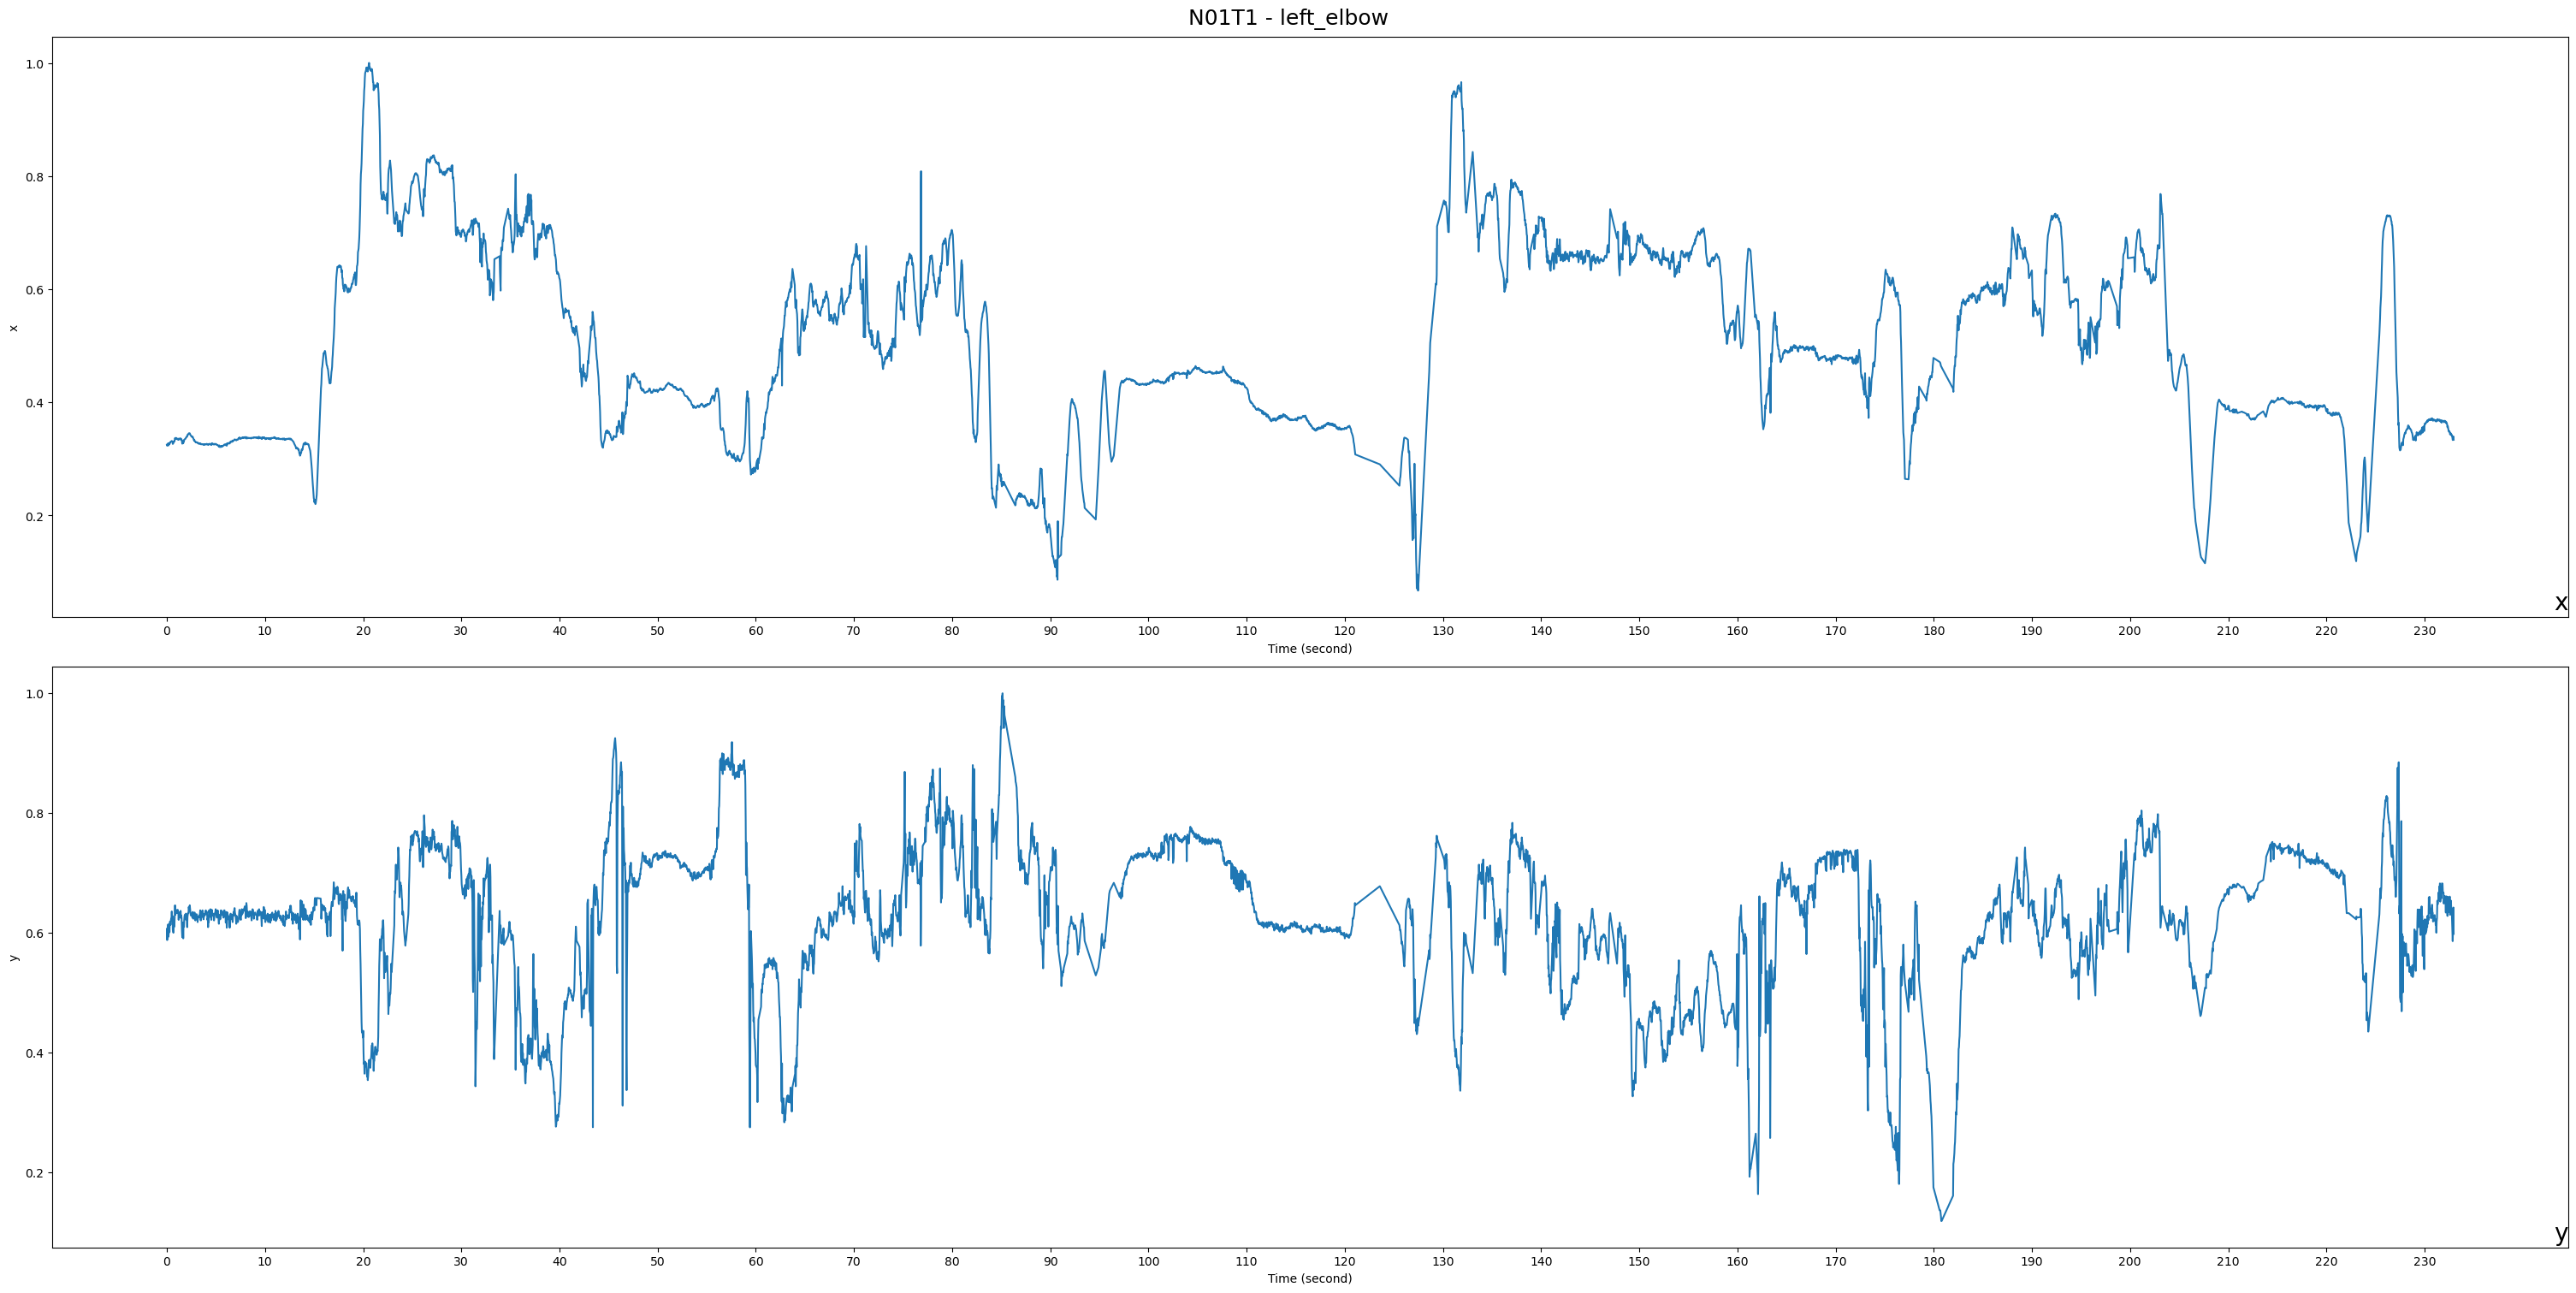

In [23]:
keypoint_position = "left_elbow"  # choose keypoint you want to visualize
values = np.array(kp_df)[:, int(KEYPOINTS_DICT[keypoint_position]*2):int(KEYPOINTS_DICT[keypoint_position]*2 + 2)]

fig = plt.figure(figsize=(30,15))
fig, axs = plt.subplots(2, 1, figsize=(30,15),  layout="constrained")
cols_name = ["x", "y"]
for x in range(2):
    axs[x].plot(values[:, x])
    axs[x].set_title(cols_name[x], y=0, loc='right', fontsize=20)
    axs[x].set_xlabel("Time (second)")
    axs[x].set_ylabel(cols_name[x])

x_ticks = np.arange(0, len(values), 10*FS)
x_ticklabels = np.arange(0, len(x_ticks))*10
plt.setp(axs, xticks=x_ticks, xticklabels=x_ticklabels)
fig.suptitle('{} - {}'.format(USER_ID, keypoint_position), size=18)
plt.show()

In [24]:
def segment(data, max_time, sub_window_size, stride_size):
    sub_windows = np.arange(sub_window_size)[None, :] + np.arange(0, max_time, stride_size)[:, None]

    row, col = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))

    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row, :]

    return data[sub_windows]

In [25]:
import scipy

def extract_feature(data, fs):
    mean_ft = np.mean(data, axis=0)
    std_ft = np.std(data, axis=0)
    max_ft = np.max(data, axis=0)
    min_ft = np.min(data, axis=0)
    var_ft = np.var(data, axis=0)
    med_ft = np.median(data, axis=0)
    sum_ft = np.sum(data, axis=0)
    std = np.std(data, axis=0)
    kurtosis=scipy.stats.kurtosis(data)
    skew=scipy.stats.skew(data)
    features = np.array([mean_ft, std_ft, max_ft, min_ft, var_ft, med_ft, sum_ft,std,kurtosis,skew]).T.flatten()
    features = np.nan_to_num(features)
    return features

In [26]:
WINDOW_SIZE = 2 # seconds
OVERLAP_RATE = 0.5 * WINDOW_SIZE # overlap 50% of window size

In [27]:
# Processing training data
all_feature = []
all_label = []

for i in range(len(ann_df)):
    seg = kp_df.loc[int(ann_df['start_time'][i]*FS): int(ann_df['stop_time'][i]*FS)]
    seg_label = ann_df["annotation"].iloc[i]
    if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
        # Calculate joint angles from keypoint data
        joint_angles = extract_joint_angles(np.array(seg))

        # Segment keypoint data and joint angles by WINDOW_SIZE and OVERLAP_RATE
        ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
        joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS,
                                        stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

        # Calculate velocity from each segment of keypoint data
        velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]

        # Calculate features from each segment of keypoint data, joint angles and velocity
        feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]
        feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in
                                  range(len(joint_angles_seg))]
        feature_velocity_seg = [extract_feature(extract_velocity(ws_seg[i]), FS) for i in range(len(ws_seg))]

        # Concatenate all features
        feature_seg = np.concatenate([feature_seg, feature_joint_angles_seg, feature_velocity_seg], axis=1)

        all_feature.extend(feature_seg)
        all_label.extend([int(seg_label)]*len(ws_seg))
print(len(feature_seg[0])) 
print(len(feature_joint_angles_seg[0]))
print(feature_seg[0])

all_feature = np.array(all_feature)

all_label = np.array(all_label)

/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/336747347.py:5: RuntimeWarning: invalid value encountered in scalar divide
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/3918008656.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis=scipy.stats.kurtosis(data)
/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/3918008656.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew=scipy.stats.skew(data)
/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/336747347.py:6: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


1060
60
[ 0.          0.          0.         ...  0.04457294 20.80699054
 -0.49352028]


In [28]:
# len(all_feature[0])

In [29]:
# Processing test data
test_all_feature = []
test_all_label = []

for i in range(len(test_ann_df)):
    seg = test_kp_df.loc[int(test_ann_df['start_time'][i]*FS): int(test_ann_df['stop_time'][i]*FS)]
    seg_label = test_ann_df["annotation"].iloc[i]
    if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
        # Calculate joint angles from keypoint data
        joint_angles = extract_joint_angles(np.array(seg))

        # Segment keypoint data and joint angles by WINDOW_SIZE and OVERLAP_RATE
        ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
        joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS,
                                        stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

        # Calculate velocity from each segment of keypoint data
        velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]

        # Calculate features from each segment of keypoint data, joint angles and velocity
        feature_seg = [extract_feature(ws_seg[i], FS) for i in range(len(ws_seg))]
        feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in
                                  range(len(joint_angles_seg))]
        feature_velocity_seg = [extract_feature(extract_velocity(ws_seg[i]), FS) for i in range(len(ws_seg))]

        # Concatenate all features
        feature_seg = np.concatenate([feature_seg, feature_joint_angles_seg, feature_velocity_seg], axis=1)

        test_all_feature.extend(feature_seg)
        test_all_label.extend([int(seg_label)]*len(ws_seg))
        
test_all_feature = np.array(test_all_feature)

test_all_label = np.array(test_all_label)

/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/336747347.py:5: RuntimeWarning: invalid value encountered in scalar divide
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/336747347.py:6: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/3918008656.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis=scipy.stats.kurtosis(data)
/var/folders/qq/ckqvfttx4vs_68cbq08jts2c0000gn/T/ipykernel_50136/3918008656.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew=scipy.stats.skew(data)


In [30]:
model_rnn = Sequential()
model_rnn.add(LSTM(units=64, return_sequences=True, input_shape=(len(all_feature[1]), 1)))
model_rnn.add(Conv1D(128, 6))
model_rnn.add(LSTM(units = 64, return_sequences = True))
model_rnn.add(Dropout(0.2))
model_rnn.add(Conv1D(128, 3))
model_rnn.add(LSTM(units = 64, return_sequences = True))

model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(units = 64))

model_rnn.add(Dense(units = 128))
model_rnn.add(Dense(units = 64))

model_rnn.add(Dense(units = 9, activation="softmax")) #4 as the output classes

# Define the BRNN model with LSTM layers
model_brnn = keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True), 
                         input_shape=(len(all_feature[1]), 1)),
#     layers.Bidirectional(layers.LSTM(64, activation='relu')),
#     layers.Bidirectional(layers.LSTM(32, activation='relu')),
    layers.Bidirectional(layers.LSTM(16, activation='relu')),
    
    layers.Dense(9, activation='softmax')
])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the RNN model
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Compile the BRNN model
model_brnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the RNN model with early stopping

## model_rnn.fit(all_feature, all_label, epochs=100, batch_size=500, validation_data=(X_vad, y_vad), callbacks=[early_stopping])

# Train the BRNN model with early stopping

model_brnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_brnn=model_brnn.fit(all_feature, all_label, epochs=10, batch_size=500,
                            validation_data=(test_all_feature, test_all_label), callbacks=[early_stopping])
# , callbacks=[early_stopping]

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.1395 - val_loss: nan - val_accuracy: 0.2957
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: nan - accuracy: 0.2651 - val_loss: nan - val_accuracy: 0.2957
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: nan - accuracy: 0.2651 - val_loss: nan - val_accuracy: 0.2957
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: nan - accuracy: 0.2651 - val_loss: nan - val_accuracy: 0.2957
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: nan - accuracy: 0.2651 - val_loss: nan - val_accuracy: 0.2957


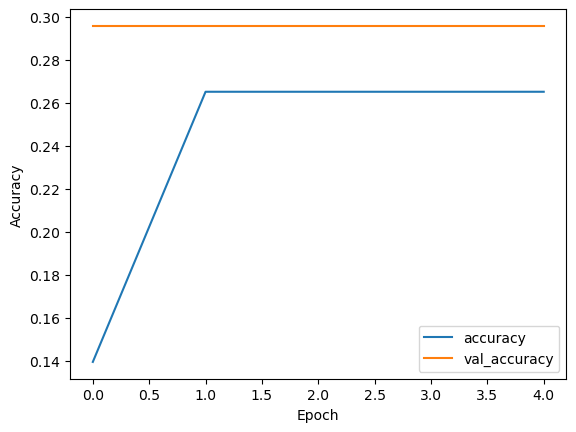

In [32]:
plt.plot(history_brnn.history['accuracy'], label='accuracy')
plt.plot(history_brnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

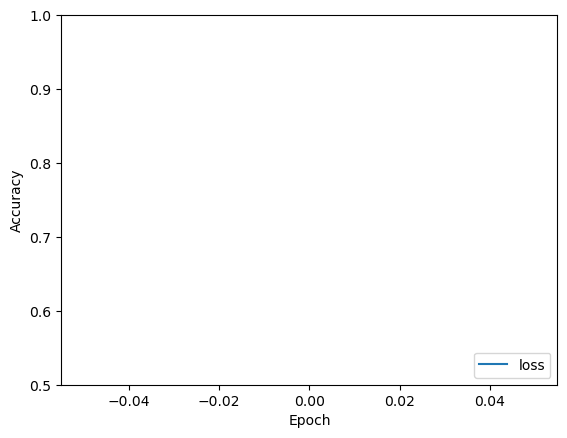

In [33]:

plt.clf()
plt.plot(history_brnn.history['loss'], label='loss')
# plt.plot(history_brnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [34]:
all_feature

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.94256053e-03, -5.08382138e-01,  3.13518780e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.98775443e-03, -5.53890888e-01,  2.84331675e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.17726634e-03,  5.55680677e-01, -1.63174958e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.46620398e-03,  5.96119680e-01,  1.12466313e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.48428824e-03,  8.98003844e+00, -2.84559584e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.05204806e-01,  5.40159040e+01,  7.48433025e+00]])

In [35]:
len(all_label)

215

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.33      0.02      0.03        65
           4       0.10      0.45      0.16        11
           5       0.60      0.06      0.10        54
           6       0.00      0.00      0.00        25
           7       0.08      0.07      0.07        90
           8       0.16      0.44      0.24         9

    accuracy                           0.07       257
   macro avg       0.14      0.12      0.07       257
weighted avg       0.25      0.07      0.07       257



<Axes: >

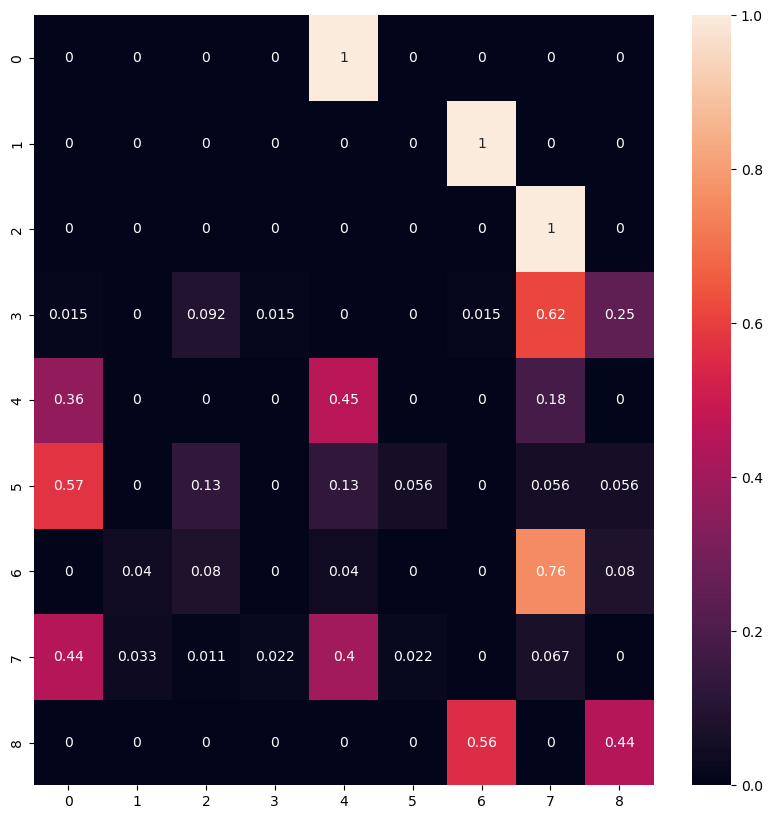

In [36]:
from xgboost import XGBClassifier#XGBcalssifier
xgbcl=XGBClassifier( eval_metric='logloss', random_state=10)
xgbcl.fit(all_feature, all_label)
pred=xgbcl.predict(test_all_feature)
from sklearn import metrics #accuracy measure
print(metrics.classification_report(pred,test_all_label))
ax,fig=plt.subplots(figsize=(10,10))
conf=metrics.confusion_matrix(pred,test_all_label, normalize='true')
sns.heatmap(conf,annot=True)

In [37]:
all_feature.shape

(215, 1060)

              precision    recall  f1-score   support

           0       0.62      0.66      0.64        71
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        16
           3       0.33      0.33      0.33         3
           4       0.30      0.34      0.32        44
           5       0.60      0.11      0.19        27
           6       0.86      0.16      0.27        38
           7       0.15      0.38      0.22        29
           8       0.72      0.62      0.67        29

    accuracy                           0.39       257
   macro avg       0.40      0.29      0.29       257
weighted avg       0.51      0.39      0.39       257



/Users/khangphan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khangphan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khangphan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

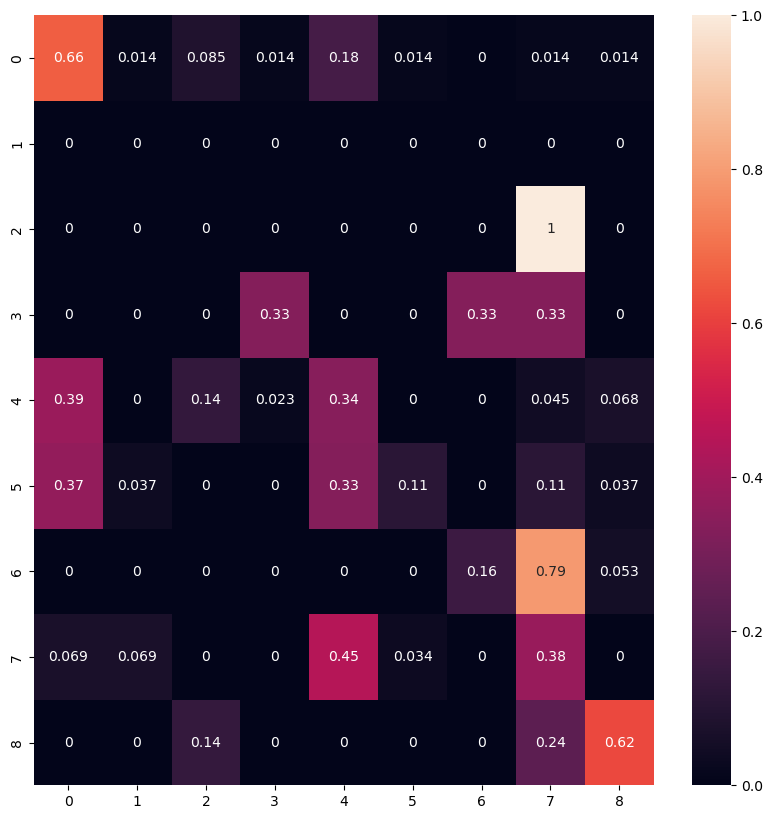

In [38]:
from sklearn.ensemble import RandomForestClassifier #Random Forest
rf=RandomForestClassifier(random_state=10)
rf.fit(all_feature, all_label)
pred=rf.predict(test_all_feature)

print(metrics.classification_report(pred,test_all_label))
ax,fig=plt.subplots(figsize=(10,10))
conf=metrics.confusion_matrix(pred,test_all_label, normalize='true')
sns.heatmap(conf,annot=True)

In [39]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
# try:
# oversampling the train dataset using SMOTE
sm = RandomOverSampler()
all_feature_smote, all_label_smote = sm.fit_resample(all_feature, all_label)
rf=RandomForestClassifier(random_state=10)
rf.fit(all_feature_smote, all_label_smote)
pred=rf.predict(test_all_feature)

print(metrics.classification_report(pred,test_all_label))
ax,fig=plt.subplots(figsize=(10,10))
conf=metrics.confusion_matrix(pred,test_all_label, normalize='true')
sns.heatmap(conf,annot=True)
# except: pass

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6

In [ ]:
df=pd.DataFrame({'a':all_label})
df['a'].value_counts()

In [ ]:
test_all_label.shape
test_all_feature.shape

In [ ]:
# from hmmlearn import hmm
# hidden_markov = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
# hidden_markov.fit(all_feature)
# pred=hidden_markov.predict(all_feature)
# print(metrics.classification_report(pred,test_all_label))
# ax,fig=plt.subplots(figsize=(10,10))
# conf=metrics.confusion_matrix(pred,test_all_label, normalize='true')
# sns.heatmap(conf,annot=True)

In [ ]:
from tensorflow.keras import models
model = models.Sequential()
model.add(layers.Conv1D(32, 32, activation='relu', input_shape=(len(all_feature[1]), 1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 64, activation='relu'))
model.add(layers.MaxPooling1D(2))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Conv1D(64, 32, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='softmax'))
# model.add(layers.Dense(32, activation='softmax'))
model.add(layers.Dense(9,activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(all_feature, all_label, epochs=10, 
                    validation_data=(test_all_feature,test_all_label), 
                    callbacks=[early_stopping])

In [ ]:
pred=model.predict(test_all_feature)
pred=np.argmax(pred,axis=1)
print(metrics.classification_report(pred,test_all_label))
ax,fig=plt.subplots(figsize=(10,10))
conf=metrics.confusion_matrix(pred,test_all_label, normalize='true')
sns.heatmap(conf,annot=True)

In [ ]:
plt.clf()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout, BatchNormalization, AveragePooling1D, ZeroPadding1D
from keras import backend as K
from keras import Sequential
from keras.initializers import glorot_uniform
X_train = np.expand_dims(all_feature, 2)
X_test = np.expand_dims(test_all_feature, 2)
y_train=tf.keras.utils.to_categorical(all_label)
y_test=tf.keras.utils.to_categorical(test_all_label)
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X
def convolutional_block(X, f, filters, stage, block, s=2):   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters=F1, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X_shortcut = Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=2, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
n_obs, feature, depth = X_train.shape
# feature,
def ResNet(input_shape=(feature,depth)):

    X_input = Input(input_shape)

    X = ZeroPadding1D(2)(X_input)
    X = Conv1D(128,128 , name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides= 2)(X)

    X = convolutional_block(X, f=3, filters=[128, 128, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling1D(pool_size= 2, padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet')
    return model
base_model = ResNet(input_shape=(feature,1))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(9,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
model = Model(inputs=base_model.input, outputs=headModel)
model.compile(
          loss = 'categorical_crossentropy',
          optimizer = 'Adam',metrics = ['AUC','accuracy']
                )
model.summary()

In [ ]:
all_feature.shape[0]

In [ ]:
h = model.fit(
      X_train,y_train,validation_data=(X_test,y_test),
                              epochs=50,batch_size=512,callbacks=[early_stopping])

In [ ]:
plt.clf()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')